In [3]:
# librerie

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql import Row
from pyspark.sql.functions import lit
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors  # Pre 2.0 pyspark.mllib.linalg
from pyspark.mllib.linalg import Vectors

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import random

In [4]:
# sessione

sc = SparkContext(appName="DDAM_Project", master="local[*]")

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("DDAM_Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=DDAM_Project, master=local[*]) created by __init__ at <ipython-input-2-c7b421bd7cd3>:3 

In [5]:
sdf=spark.read.parquet("hdfs://kddrtserver11.isti.cnr.it:9000/user/hpsa04/bank_loan_status_dataset")
    
columns = sdf.schema.names

columns_categorical = [col.name for col in sdf.schema.fields if isinstance(col.dataType, StringType)]

columns_numerical = [col for col in columns if col not in columns_categorical]

sdf.printSchema()

root
 |-- Loan_Status: string (nullable = true)
 |-- Current_Loan_Amount: long (nullable = true)
 |-- Term: string (nullable = true)
 |-- Credit_Score: double (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Years_in_current_job: string (nullable = true)
 |-- Home_Ownership: string (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Monthly_Debt: double (nullable = true)
 |-- Years_of_Credit_History: double (nullable = true)
 |-- Months_since_last_delinquent: string (nullable = true)
 |-- Number_of_Open_Accounts: string (nullable = true)
 |-- Number_of_Credit_Problems: string (nullable = true)
 |-- Current_Credit_Balance: long (nullable = true)
 |-- Maximum_Open_Credit: long (nullable = true)
 |-- Bankruptcies: string (nullable = true)
 |-- Tax_Liens: string (nullable = true)



# 1. Variable Description

Clarifications for the less intuitive variables:

- Monthly_Debt: rata mensile (Monthly debt payments are any payments you make to pay back a creditor or lender for money you                   borrowed)

- Years_of_Credit_History: A consumer's credit history is a measure of their ability to repay debts and demonstrated responsibility in repaying debts. A person's credit history is recorded in their credit report. A consumer's credit report details the number and types of credit accounts, how long each account has been open, amounts owed, the amount of available credit used, whether bills are paid on time, and the number of recent credit inquiries. 

- Number_of_Open_Accounts: numero di conti correnti aperti (The open account definition is an account which remains to be paid. Open account is also known as an account payable by the bearer.)
- Number_of_Credit_Problems: numero di insoluti, rate pagate in ritardo, ha una media molto bassa 0.1638154665918811 e un range                              [0-15]. Quindi la maggior parte dei clienti nel passato non ha avuto problemi (85578 righe con                                  valore 0).[Lack of enough credit history, Denied credit application, Fraud and identity theft]
- Tax_Liens: Un vincolo fiscale è un vincolo imposto dalla legge su una proprietà per garantire il pagamento delle imposte.
- Current_Loan_Amount:Loan Amount is the amount the borrower promises to repay, as set forth in the loan contract. Importo del/dei prestito/i aperti
- Current_Credit_Balance: the amount of money that a client of a financial institution has in his or her account [https://www.collinsdictionary.com/dictionary/english/credit-balance] Quindi è il saldo del conto corrente.
- Maximum_Open_Credit: An open credit is a financial arrangement between a lender and a borrower that allows the latter to access credit repeatedly up to a specific maximum limit. (Non sono sicura che si riferisca esattamente a questa tipologia, ma comunque la variabile si riferisce al tetto massimo di prestito che può essere concesso al soggetto)

# 2. Data Understanding
## 2.1. General Statistics 
Even though the original dataset provided was relatively small (10MB), in order to simulate a Big Data analysis, Pandas library was only used on data previously reduced using pySpark. E.g. in the example below, only 3 colums from a total of 17 (?) were used which cut the amount of data by more than 82% of the original dataset.

In [9]:
sdf.createOrReplaceTempView('Bank_Loan_Dataset')
for col in columns_numerical:
    print(col)
    sql = """
    SELECT  AVG({0}) as Average, COUNT(DISTINCT {0}) AS N_Distinct, MIN(CAST({0} AS DOUBLE)) AS Minimum, MAX(CAST({0} AS DOUBLE)) AS Maximum, PERCENTILE(CAST({0} AS DOUBLE),0.5) AS Median
    FROM Bank_Loan_Dataset
    """.format(col)

    spark.sql(sql).show()

Current_Loan_Amount
+------------------+----------+-------+--------+--------+
|           Average|N_Distinct|Minimum| Maximum|  Median|
+------------------+----------+-------+--------+--------+
|307662.56121754495|     21442|10802.0|789250.0|265210.0|
+------------------+----------+-------+--------+--------+

Credit_Score
+-----------------+----------+-------+-------+------+
|          Average|N_Distinct|Minimum|Maximum|Median|
+-----------------+----------+-------+-------+------+
|717.7991412713554|       176|  585.0|  751.0| 721.0|
+-----------------+----------+-------+-------+------+

Annual_Income
+------------------+----------+-------+----------+---------+
|           Average|N_Distinct|Minimum|   Maximum|   Median|
+------------------+----------+-------+----------+---------+
|1370609.3146455411|     31722|76627.0|3.647544E7|1227096.0|
+------------------+----------+-------+----------+---------+

Monthly_Debt
+------------------+----------+-------+---------+--------+
|           A

In [42]:
#check the average credit score for both charged off and fully paid Loan Status

sdf.select('Loan_Status','Credit_Score','Years_of_Credit_History')\
.groupBy('Loan_Status').avg('Credit_Score').toPandas()



Loan_Status  avg(Credit_Score)
0   Fully Paid         719.725008
1  Charged Off         712.323673

In [43]:
#Check the Average credit score for both charged off and fully paid Loan Status for people with
#more that 10 years of credit history

sdf.select('Loan_Status','Credit_Score','Years_of_Credit_History')\
.filter(sdf["Years_of_Credit_History"] > 10).groupBy('Loan_Status').avg('Credit_Score').show()

+-----------+-----------------+
|Loan_Status|avg(Credit_Score)|
+-----------+-----------------+
| Fully Paid|720.1584968537525|
|Charged Off|712.6696641227351|
+-----------+-----------------+



In [10]:
rdd=sdf[columns_numerical].rdd
rdd=rdd.map(lambda row: Vectors.dense(row))

Correlation matrices: heatmap on a sampled dataset at the end of the notebook

In [11]:
Statistics.corr(rdd, method="spearman") 

array([[ 1.        , -0.20351224,  0.51095217,  0.43175338,  0.16609012,
         0.46726261,  0.43113713],
       [-0.20351224,  1.        , -0.01438045, -0.105721  ,  0.10531364,
        -0.03542261,  0.11886664],
       [ 0.51095217, -0.01438045,  1.        ,  0.61129994,  0.27672409,
         0.42398366,  0.41830946],
       [ 0.43175338, -0.105721  ,  0.61129994,  1.        ,  0.21342017,
         0.5192378 ,  0.41866952],
       [ 0.16609012,  0.10531364,  0.27672409,  0.21342017,  1.        ,
         0.26643739,  0.28986855],
       [ 0.46726261, -0.03542261,  0.42398366,  0.5192378 ,  0.26643739,
         1.        ,  0.76841276],
       [ 0.43113713,  0.11886664,  0.41830946,  0.41866952,  0.28986855,
         0.76841276,  1.        ]])

In [12]:
Statistics.corr(rdd) 

array([[ 1.        , -0.23179647,  0.44262801,  0.43205972,  0.15214967,
         0.3436144 ,  0.03212403],
       [-0.23179647,  1.        , -0.01626563, -0.09664462,  0.08089207,
        -0.02560872,  0.01151542],
       [ 0.44262801, -0.01626563,  1.        ,  0.58935856,  0.20034073,
         0.40785625,  0.06214561],
       [ 0.43205972, -0.09664462,  0.58935856,  1.        ,  0.19399886,
         0.48311267,  0.03099098],
       [ 0.15214967,  0.08089207,  0.20034073,  0.19399886,  1.        ,
         0.21566889,  0.02872519],
       [ 0.3436144 , -0.02560872,  0.40785625,  0.48311267,  0.21566889,
         1.        ,  0.12367365],
       [ 0.03212403,  0.01151542,  0.06214561,  0.03099098,  0.02872519,
         0.12367365,  1.        ]])

## 2.2. Explorative Analysis

In [44]:
#percentage of different types of home owners with regards to their Loan Status

pdf=sdf.select('Home_Ownership','Loan_Status').toPandas()

pclass_xt = pd.crosstab(pdf['Home_Ownership'], pdf['Loan_Status'])

pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

pclass_xt_pct

Loan_Status     Charged Off  Fully Paid
Home_Ownership                         
HaveMortgage       0.166667    0.833333
Home Mortgage      0.234209    0.765791
Own Home           0.263183    0.736817
Rent               0.290013    0.709987

<IPython.core.display.Javascript object>


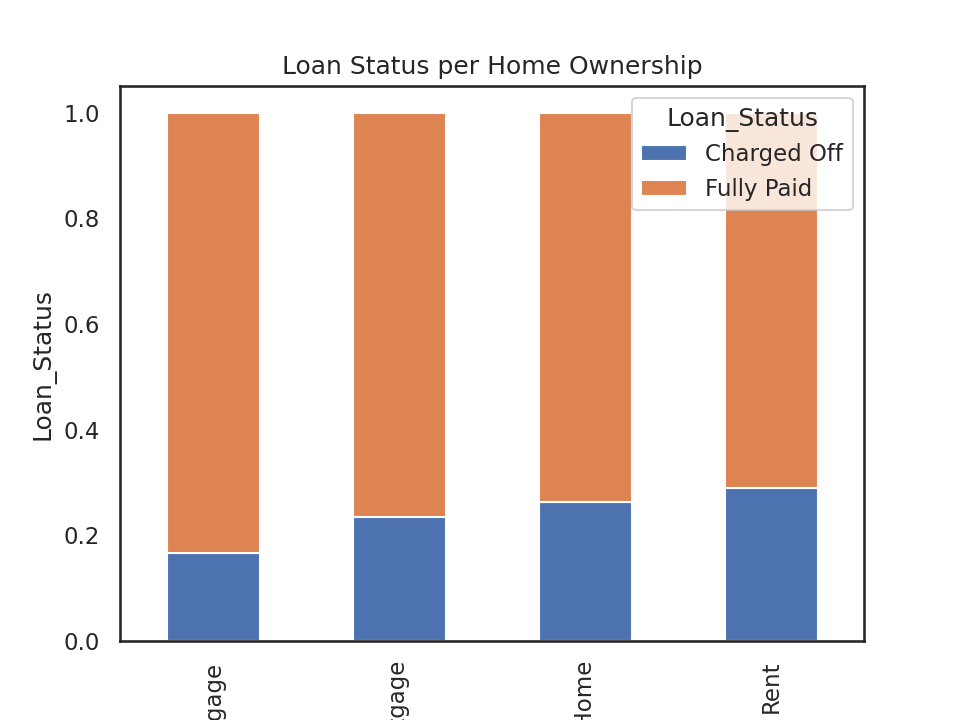

In [45]:
pclass_xt_pct.plot(kind='bar', stacked=True, 
                   title='Loan Status per Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Loan_Status')
plt.show()

<IPython.core.display.Javascript object>


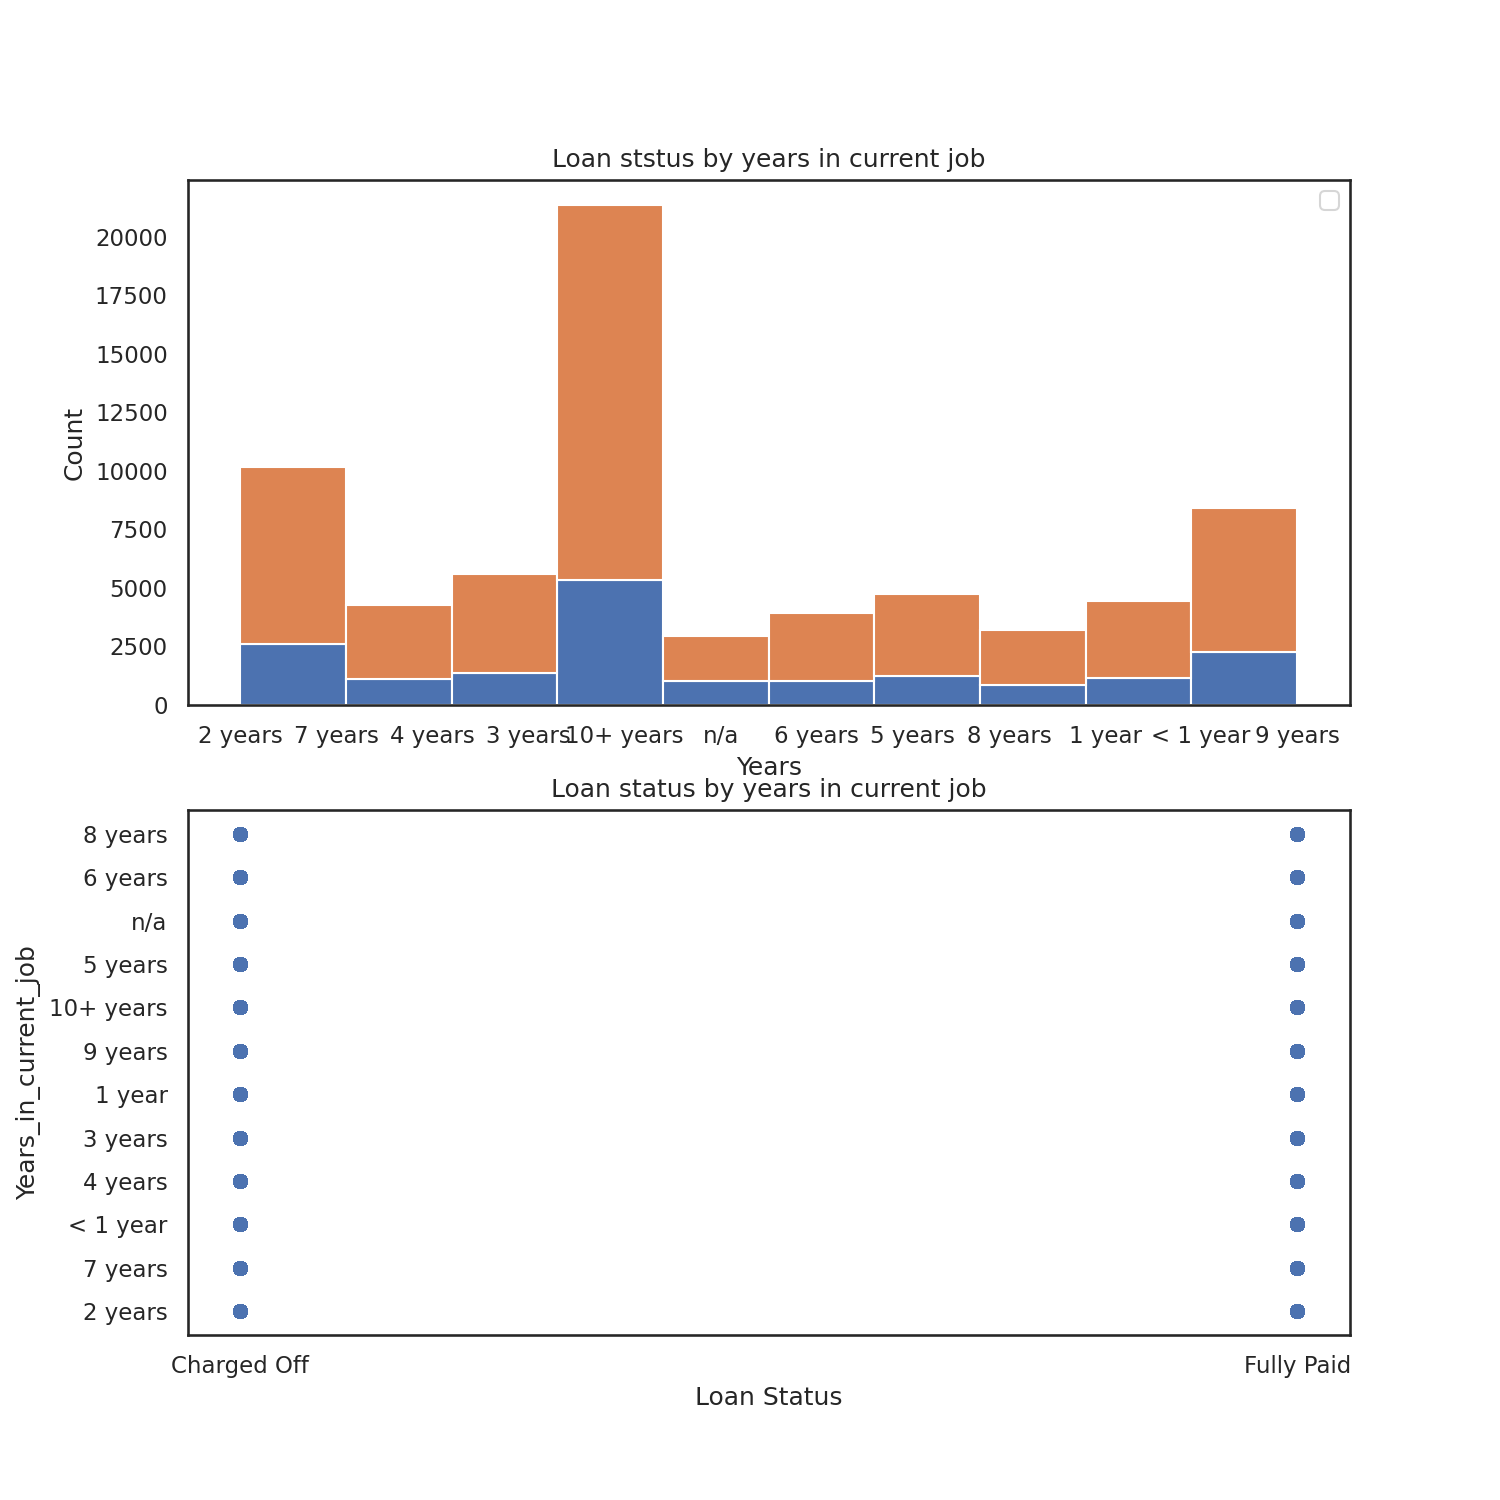

Text(0, 0.5, 'Years_in_current_job')

In [46]:
#https://stackoverflow.com/questions/22635110/sorting-the-order-of-bars-in-pandas-matplotlib-bar-plots
#ORDER THESE VALUES once Lorenzo finishes w data preparation


fig, axes = plt.subplots(2, 1, figsize=(10,10))

pdf=sdf.select('Years_in_current_job','Loan_Status').toPandas()

df1 = pdf[pdf['Loan_Status'] == 'Charged Off']['Years_in_current_job']
df2 = pdf[pdf['Loan_Status'] == 'Fully Paid']['Years_in_current_job']

axes[0].legend(('Charged Off', 'Fully Paid'), loc='best')
axes[0].set_title('Loan ststus by years in current job')
axes[0].set_xlabel('Years')
axes[0].set_ylabel('Count')

axes[0].hist([df1, df2], 
             stacked=True)
axes[1].scatter(pdf['Loan_Status'], pdf['Years_in_current_job'])
axes[1].set_title('Loan status by years in current job')
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Years_in_current_job')

In [63]:
pdf=sdf.select('Annual_Income','Credit_Score').toPandas()

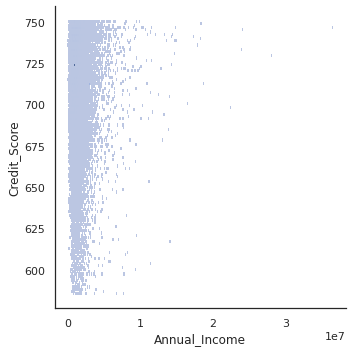

In [64]:
sns.displot(x='Annual_Income',y="Credit_Score", data=pdf)
plt.show()

## Boxplot Analysis

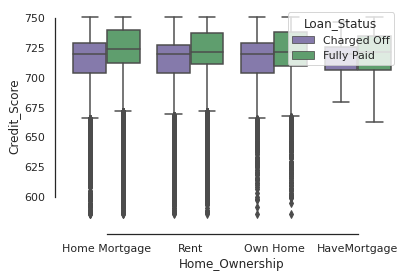

In [65]:
 #plots in seaborn and matplot lib no longer showing? Might it have sth w matplotlib inline?
pdf=sdf.select('Loan_Status','Credit_Score','Home_Ownership').toPandas()
sns.boxplot(x="Home_Ownership",  y="Credit_Score",
            
            hue="Loan_Status", palette=["m", "g"],
            
            data=pdf)

sns.despine(offset=10, trim=True)
     

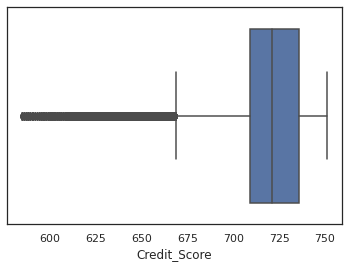

In [66]:
ax = sns.boxplot(x=pdf["Credit_Score"])

## Iterating Simple Types of Charts over a Sampled and Balanced Dataset

Another method of reducing the amount of data used is sampling with balenced proportions: still having the simulation of Big Data in mind, sample the dataset approximately 0.4%  of the original size while maintaining the proportions of the Loan Status values at approx 50:50 and then convert it to a Pandas dataframe in order to apply pandas, seaborn and matplotlib methods not present in pySpark. This is a way of balancing the dataset, which was done here only for the visualization purposes.

In [13]:
d={'Fully Paid': 0.002, 'Charged Off': 0.002*3}


#there is approximately 3 times less 'Charged Off' values for the
#Loan Status variable. This way we are going to be able to visualize 
#better the distribution of Fully Paid vs Charged Off Data points.

sd=sdf[columns].stat.sampleBy("Loan_Status", d, seed=42) #sampled dataframe

pdf=sd.toPandas() #sampled datadrame converted to a pandas dataframe

In [68]:
print('Lenght of a new, reduced Pandas dataframe: %d. Lenght of the original Spark Dataframe: %d'%(len(pdf), sdf.count()))

Lenght of a new, reduced Pandas dataframe: 213. Lenght of the original Spark Dataframe: 69057


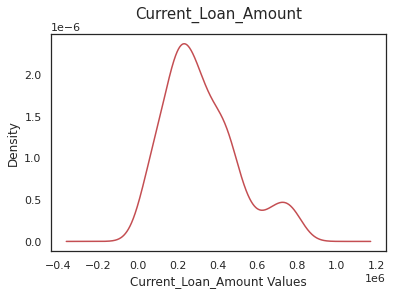

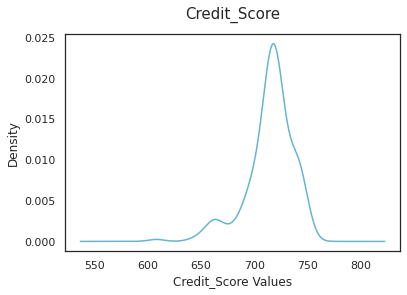

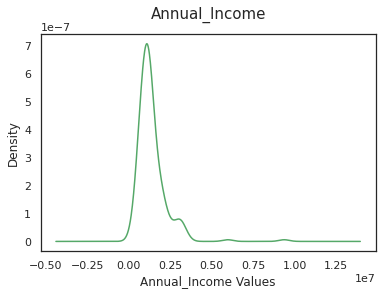

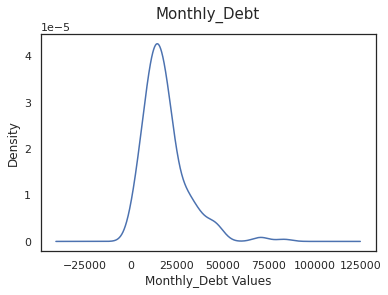

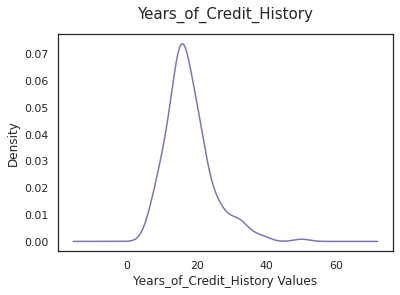

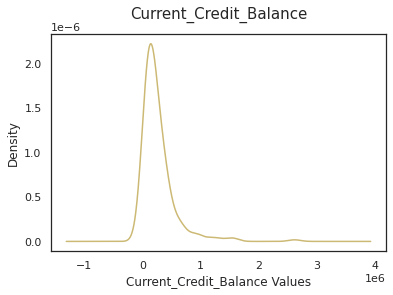

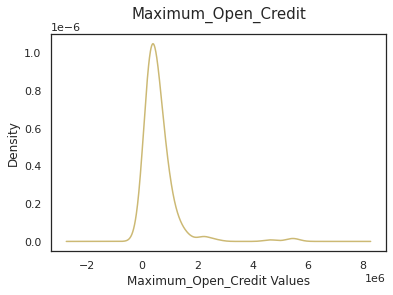

In [69]:
c=['b', 'g', 'r', 'c', 'm', 'y', 'k']

for col in columns_numerical:

        pdf[col].plot(kind='kde',color=random.choice(c))

        plt.title(col, pad=15, size=15)

        plt.xlabel(col + ' Values', size=12)

        plt.show()


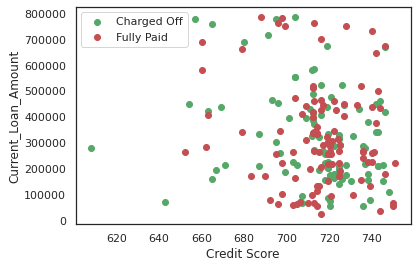

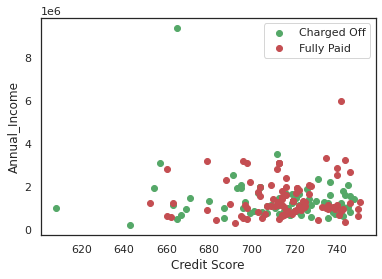

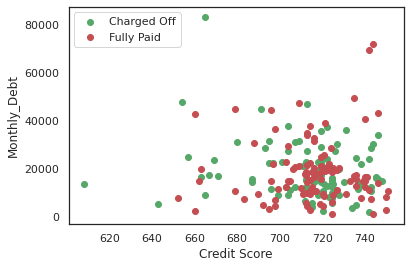

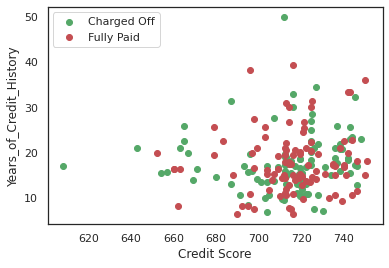

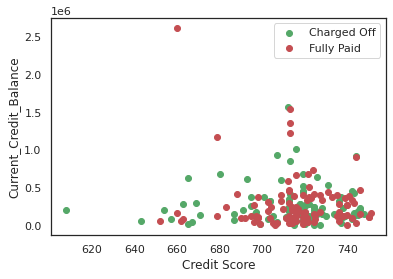

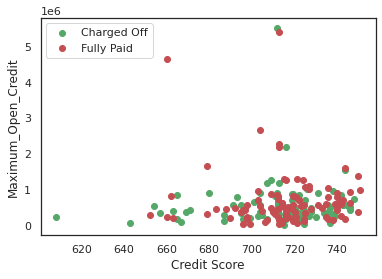

In [70]:
#perchè non plotta? Prima plottava senza problemi
for col in columns_numerical:
        #print(col)
        if col!='Credit_Score':
           # print(col)
            
            plt.scatter(pdf[pdf['Loan_Status'] == 'Charged Off']['Credit_Score'], 
                        
                        pdf[pdf['Loan_Status'] == 'Charged Off'][col], color='g', label='Charged Off')
            
            plt.scatter(pdf[pdf['Loan_Status'] == 'Fully Paid']['Credit_Score'], 
                        
                        pdf[pdf['Loan_Status'] == 'Fully Paid'][col], color='r',label='Fully Paid')
            
            plt.xlabel('Credit Score')
            
            plt.ylabel(col)
            
            plt.legend()
            
            plt.show()


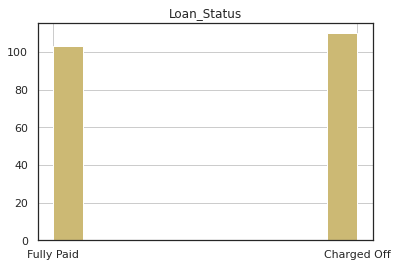

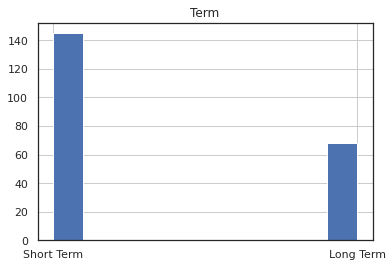

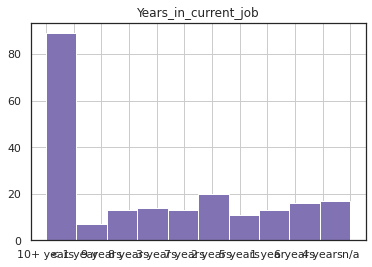

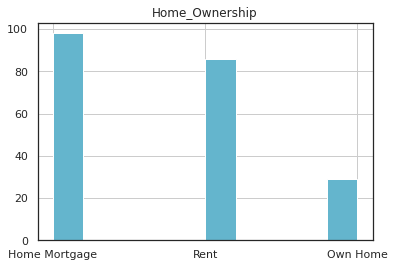

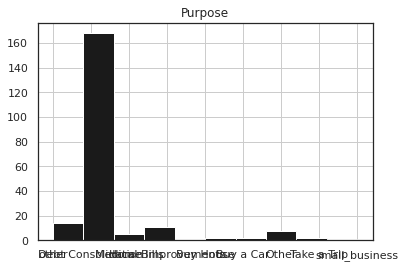

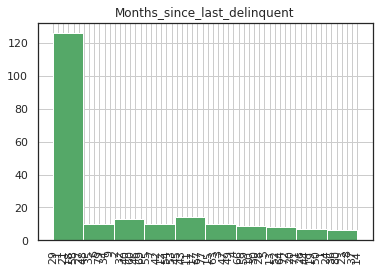

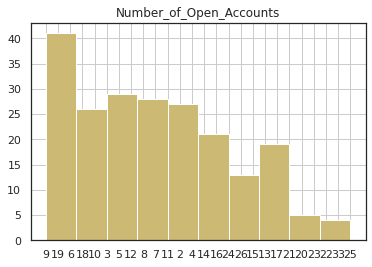

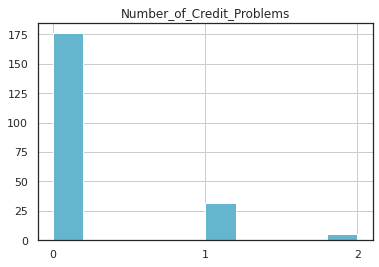

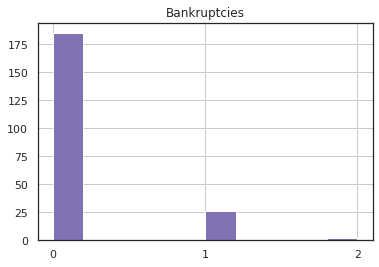

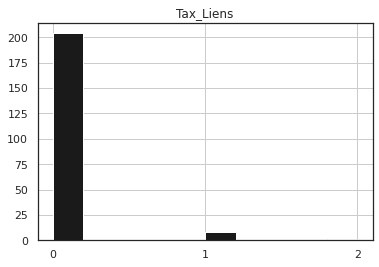

In [71]:
for col in (columns_categorical):
    
        pdf[col].hist(color=random.choice(c))
        
        plt.title(col)
        
        if pdf[col].nunique()>30:
            
            plt.xticks(rotation='vertical')
            
        plt.show()

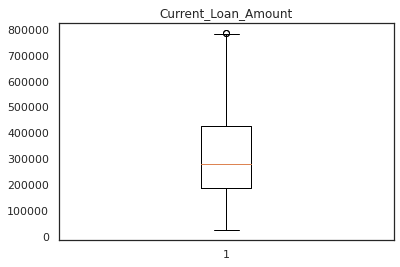

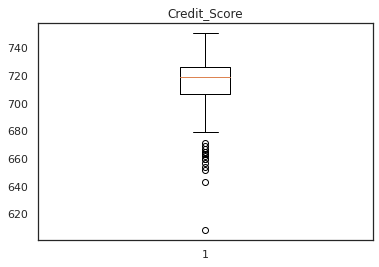

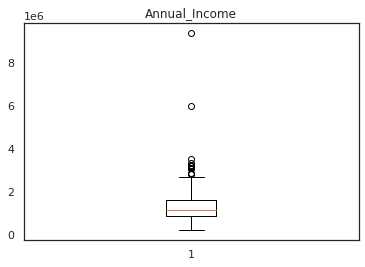

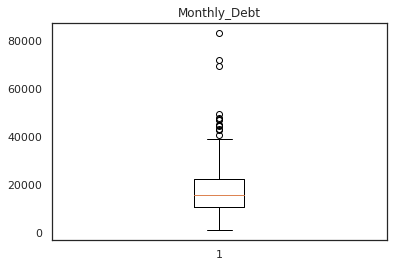

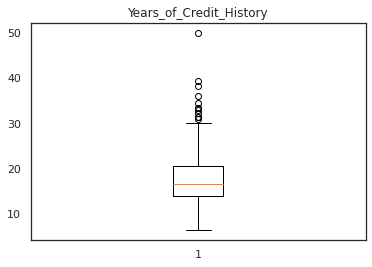

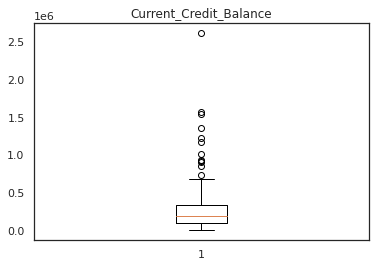

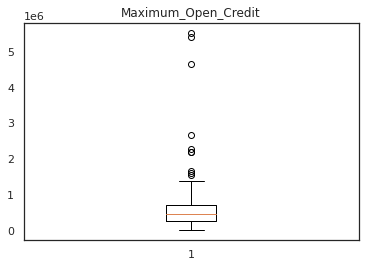

In [72]:
for col in columns_numerical:
    plt.boxplot(pdf[col])
    plt.title(col)
    plt.show()

In [78]:
%matplotlib notebook 
#for zoomable plots

<IPython.core.display.Javascript object>


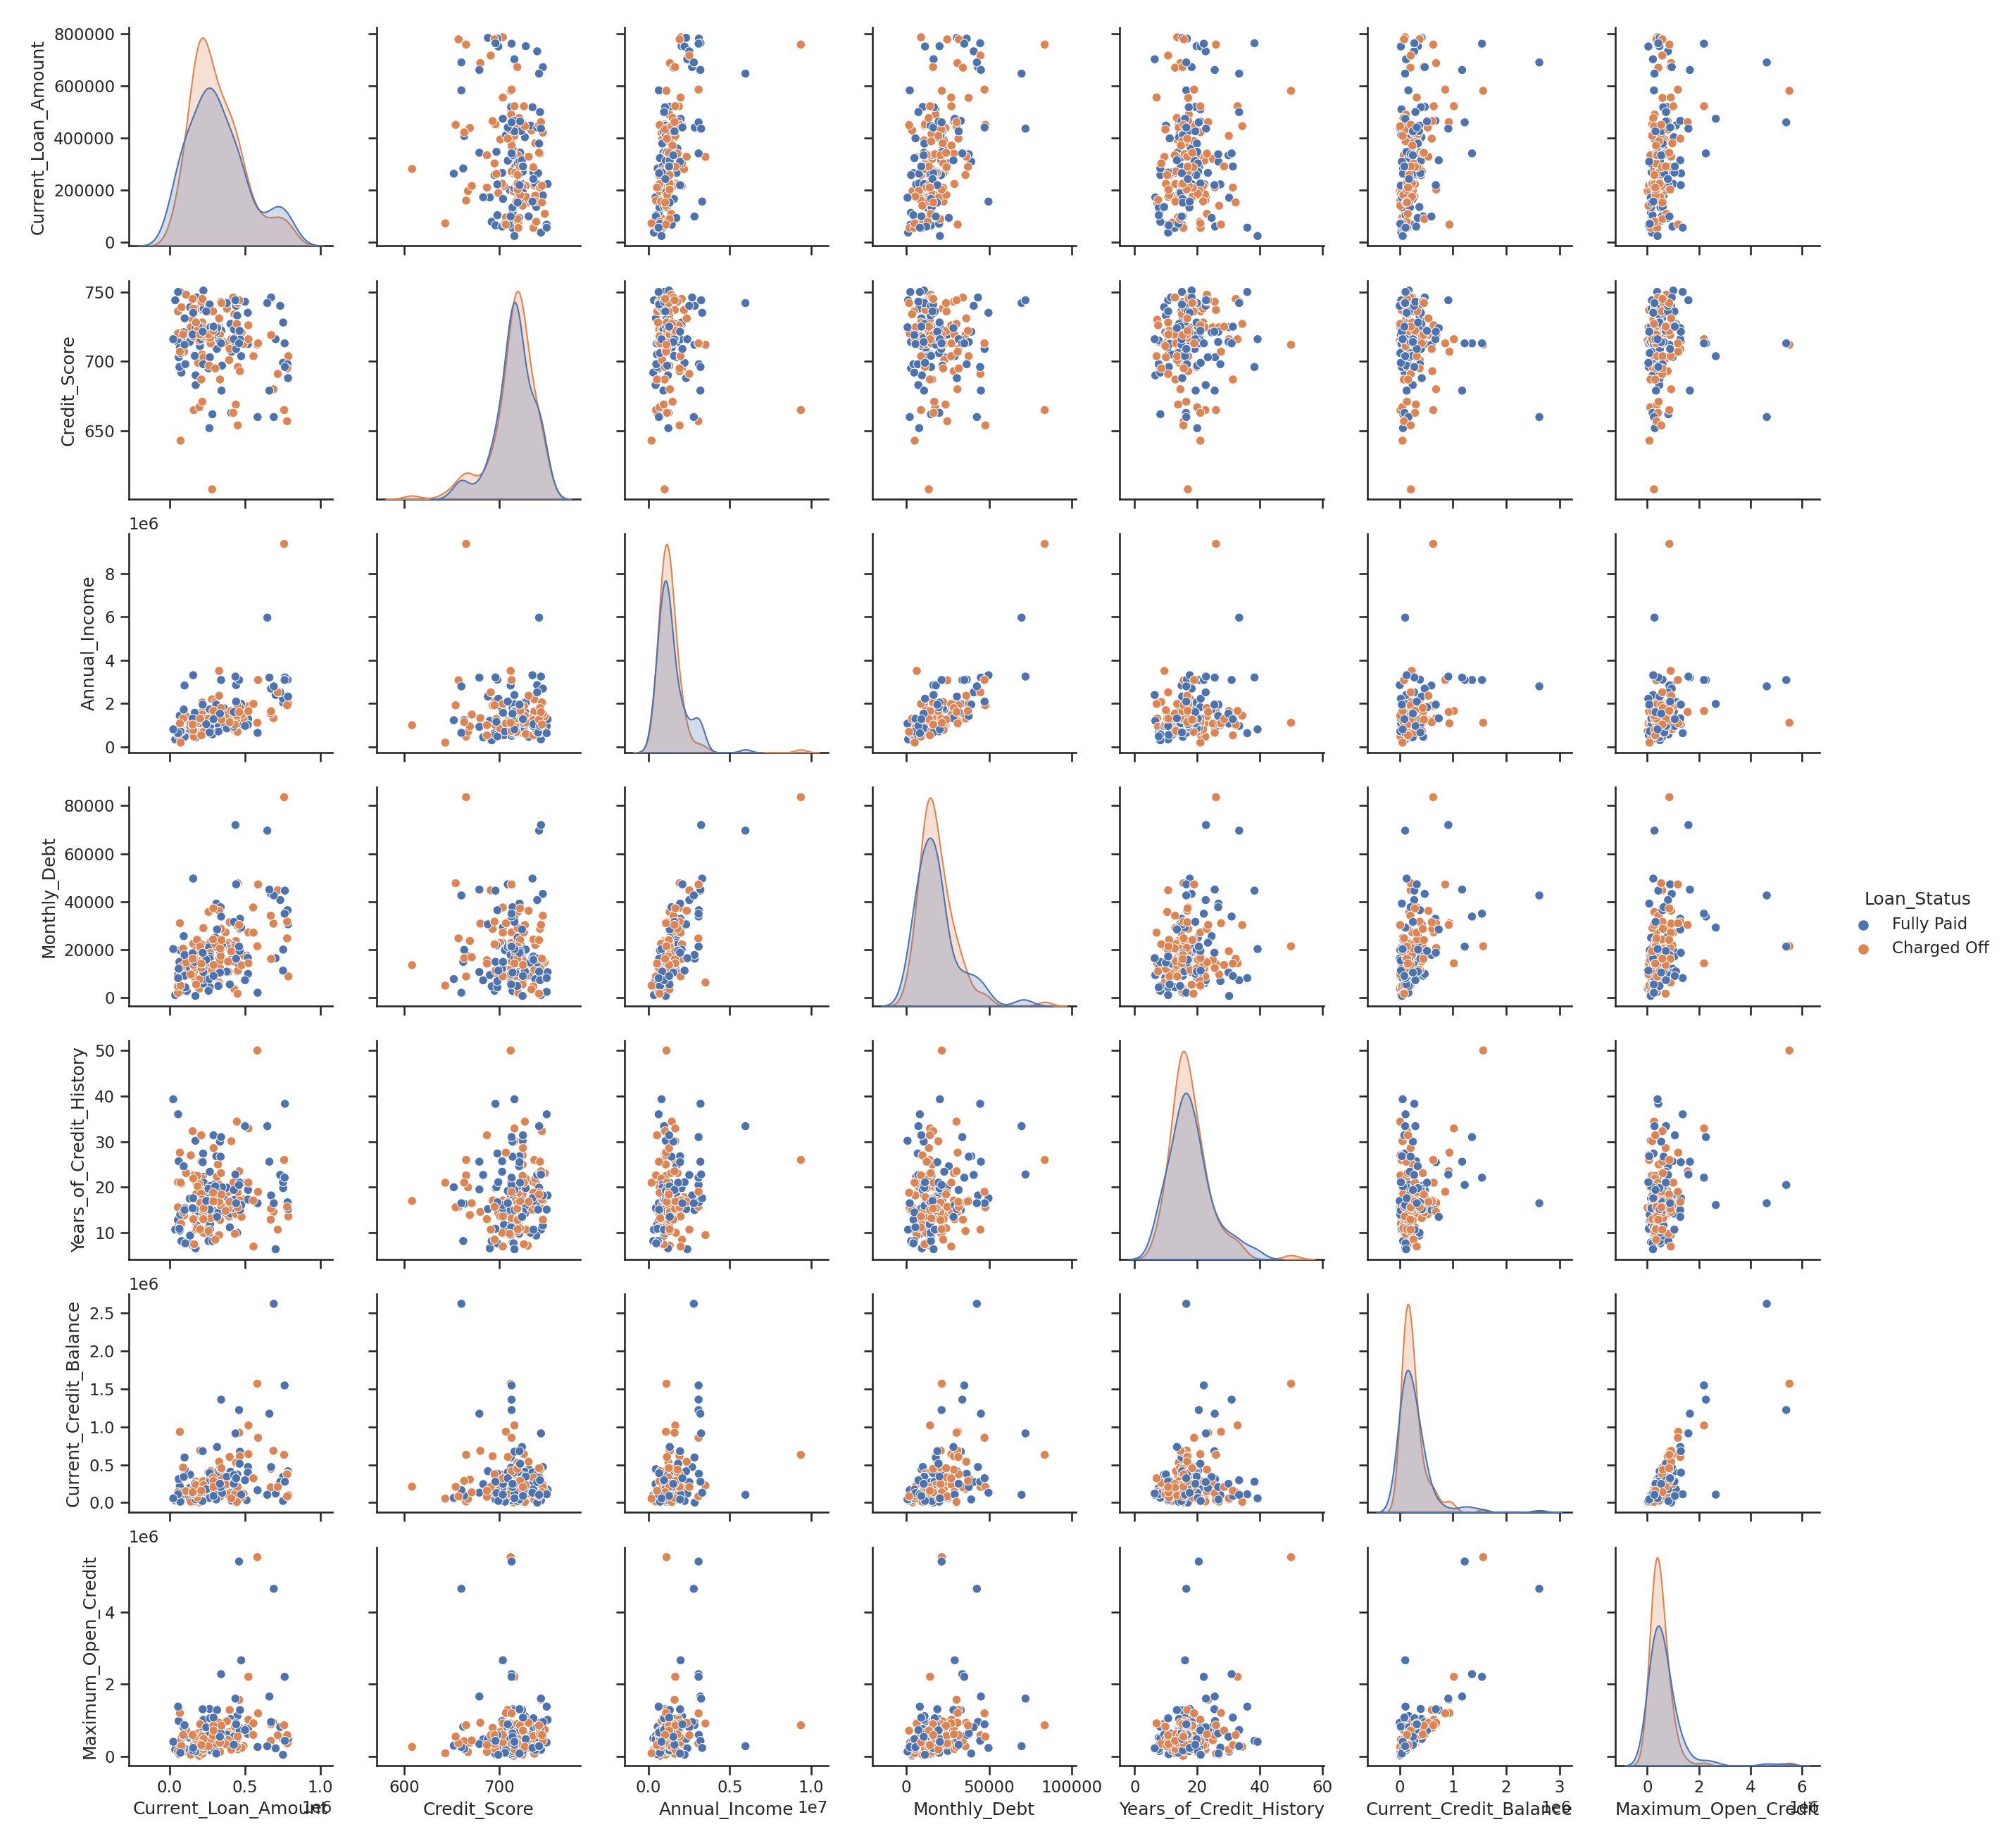

In [79]:
sns.set_theme(style="ticks")


sns.pairplot(pdf[columns_numerical+['Loan_Status']], hue="Loan_Status")

<IPython.core.display.Javascript object>


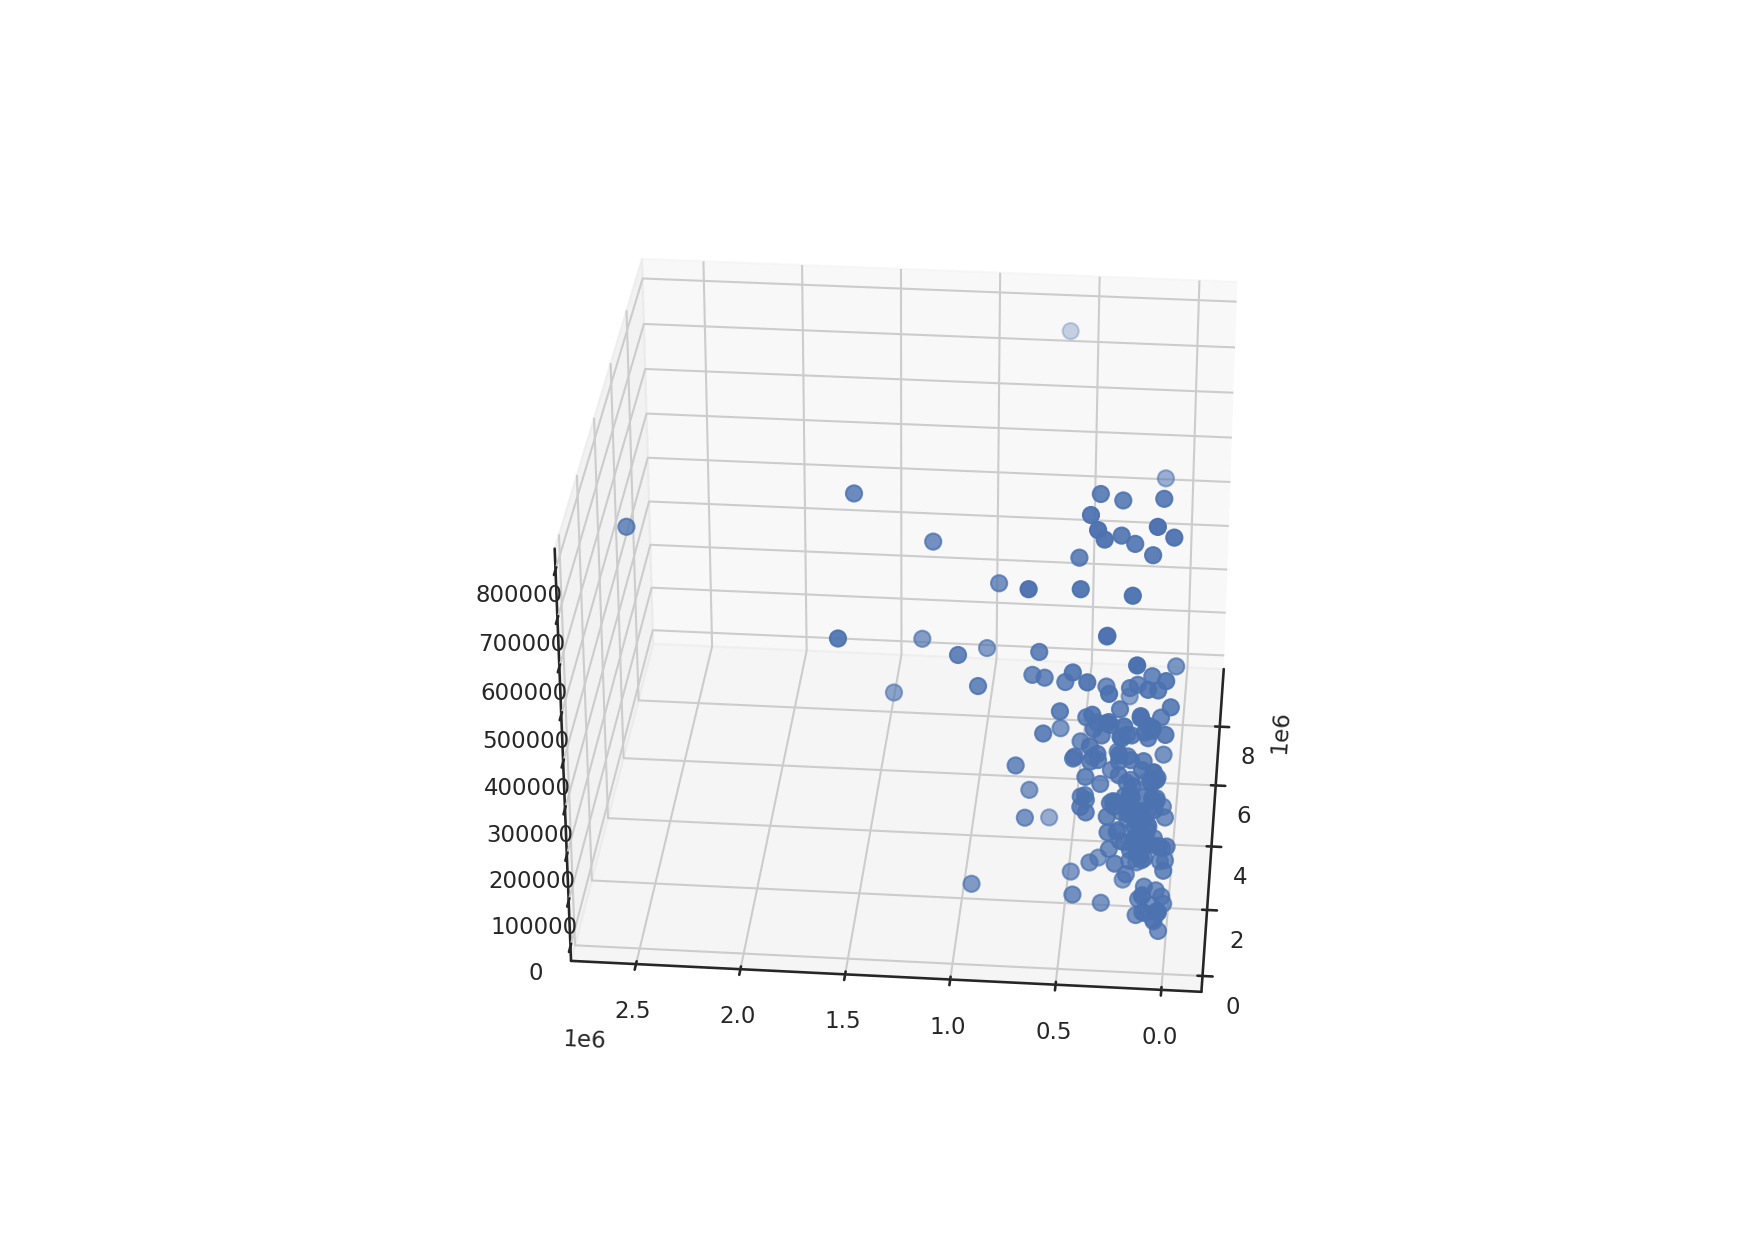

In [80]:
fig = plt.figure()

fig.set_size_inches(11.7, 8.27)

ax = fig.add_subplot( projection='3d')

cmap = ListedColormap(sns.color_palette("magma", 256).as_hex())

ax.scatter(pdf['Annual_Income'], pdf['Current_Credit_Balance'], pdf['Current_Loan_Amount'],cmap=plt.cm.viridis, s=60)

ax.view_init(30, 185)

plt.show()

Different libraries were used in order to plot insightful visual representations of the dataset. It is advised to install the plotly.express library and try rotating and zooming in and out of the 3D plot in order to get a better view of the data.

In [14]:
fig = px.scatter_3d(pdf, x=pdf['Annual_Income'], y=pdf['Current_Credit_Balance'], z=pdf['Current_Loan_Amount'], 
                    color=pdf['Loan_Status'],size=[0.01 for i in range (len(pdf))])

fig.show()

In [15]:
fig = px.scatter_3d(pdf, y=pdf['Annual_Income'], z=pdf['Current_Loan_Amount'], x=pdf['Credit_Score'], 
                    color=pdf['Loan_Status'], size=[0.01 for i in range (len(pdf))])
fig.show()

In [16]:
fig = px.scatter_3d(pdf, x=pdf['Current_Loan_Amount'], y=pdf['Maximum_Open_Credit'], z=pdf['Credit_Score'],
                    color=pdf['Home_Ownership'], size=[0.01 for i in range (len(pdf))])
fig.show()

### Correlation Matrix Heatmap

<IPython.core.display.Javascript object>


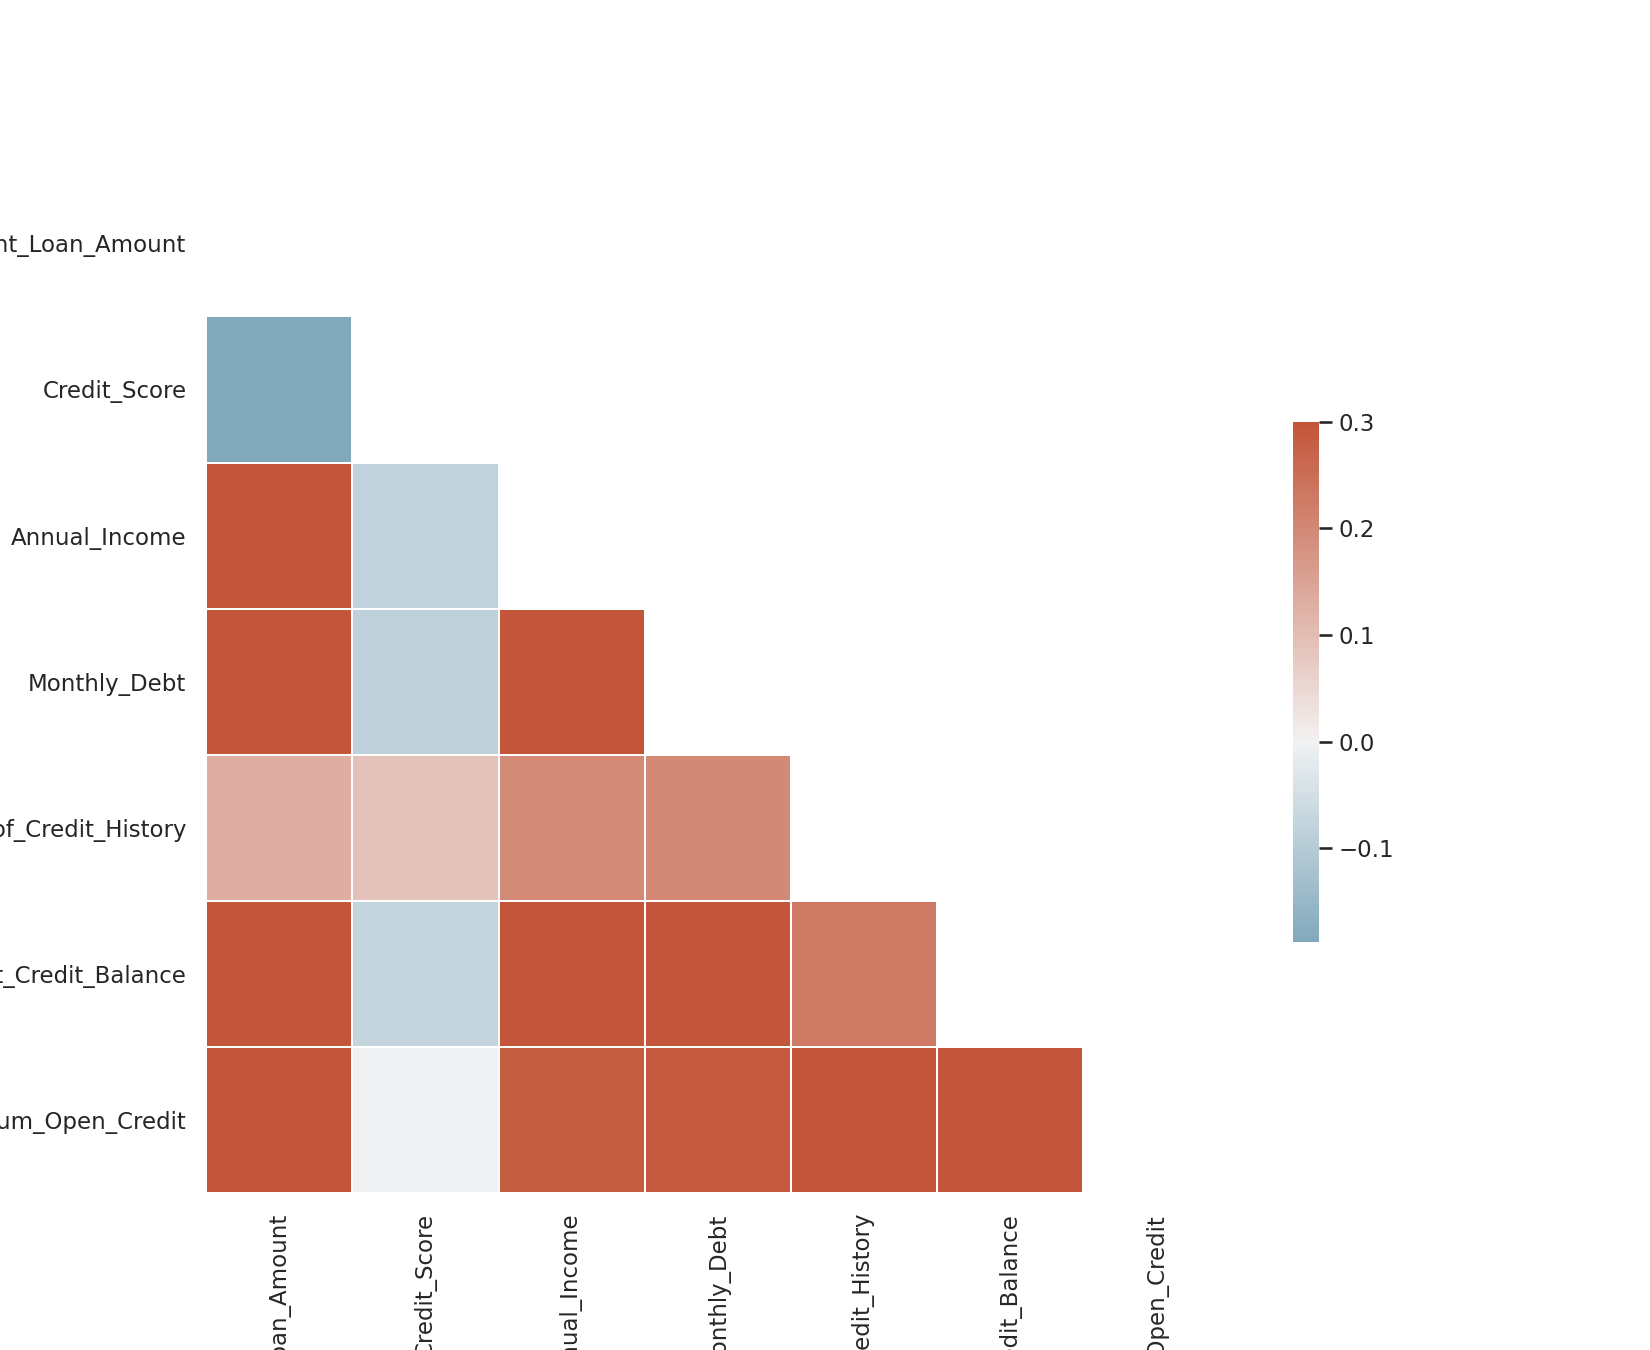

<AxesSubplot:>

In [85]:
sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
#                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pdf[columns_numerical].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Home_Ownership:


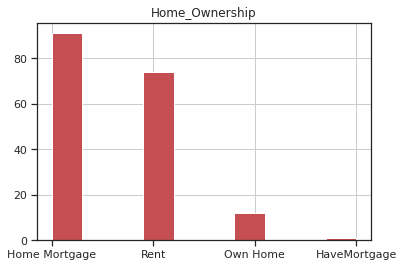



Loan_Status     Charged Off  Fully Paid
Home_Ownership                         
HaveMortgage       1.000000    0.000000
Home Mortgage      0.516484    0.483516
Own Home           0.250000    0.750000
Rent               0.527027    0.472973




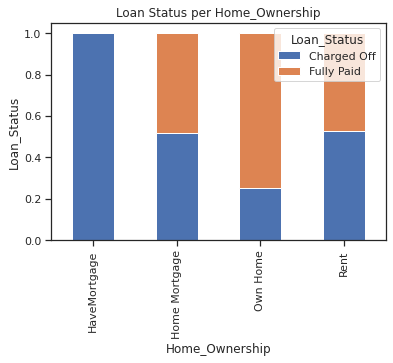


Months_since_last_delinquent:


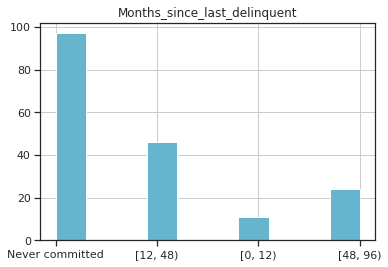



Loan_Status                   Charged Off  Fully Paid
Months_since_last_delinquent                         
Never committed                  0.494845    0.505155
[0, 12)                          0.545455    0.454545
[12, 48)                         0.521739    0.478261
[48, 96)                         0.500000    0.500000




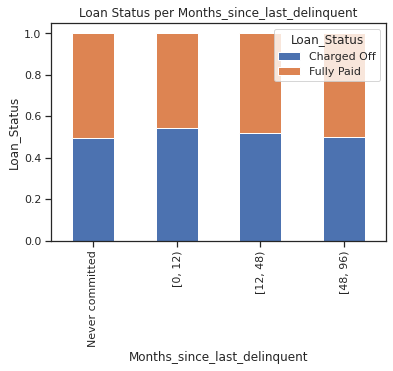


Purpose:


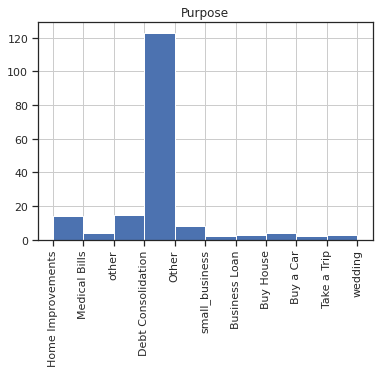



Loan_Status         Charged Off  Fully Paid
Purpose                                    
Business Loan          0.666667    0.333333
Buy House              0.750000    0.250000
Buy a Car              0.500000    0.500000
Debt Consolidation     0.495935    0.504065
Home Improvements      0.500000    0.500000
Medical Bills          0.750000    0.250000
Other                  0.375000    0.625000
Take a Trip            0.500000    0.500000
other                  0.466667    0.533333
small_business         1.000000    0.000000
wedding                0.000000    1.000000




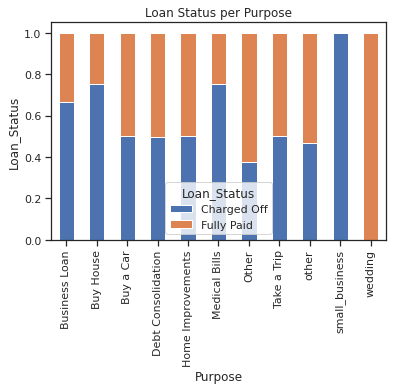


Term:


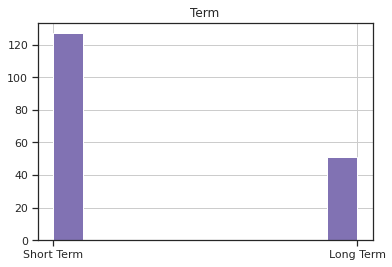



Loan_Status  Charged Off  Fully Paid
Term                                
Long Term       0.647059    0.352941
Short Term      0.448819    0.551181




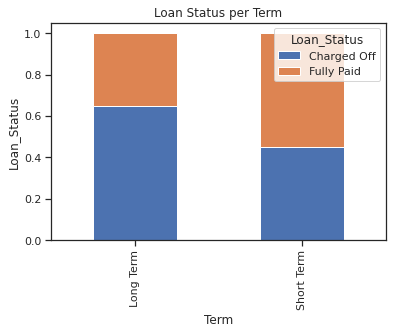

In [18]:
for col in (columns_categorical):
    
    if col == 'Loan_Status':
        continue
        
    print('\n' + col + ':')
    
    pdf[col].hist(color=random.choice(c))

    plt.title(col)

    if pdf[col].nunique()>10:

        plt.xticks(rotation='vertical')

    plt.show()
    
    print('\n')

    pclass_xt = pd.crosstab(pdf[col], pdf['Loan_Status'])

    pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)

    print(pclass_xt_pct)
    
    print('\n')
    
    pclass_xt_pct.plot(kind='bar', stacked=True, title='Loan Status per ' + col)
    plt.xlabel(col)
    plt.ylabel('Loan_Status')
    plt.show()